Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

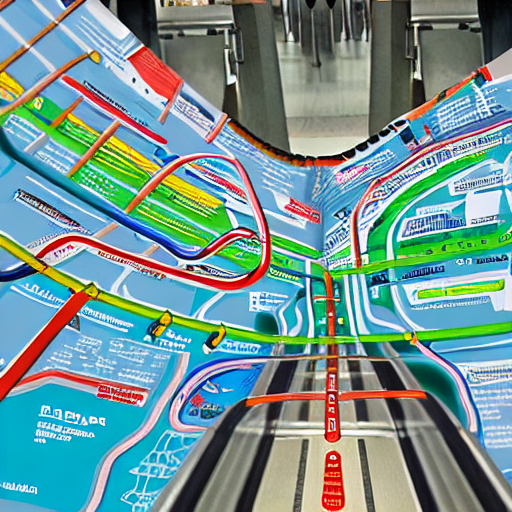

In [5]:
from diffusers import DiffusionPipeline
import torch
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32)
pipeline. to ("mps")
pipeline.enable_attention_slicing()
pipeline("singapore mrt map").images[0]

In [2]:
#example python run.py examples/data/000.png --output-dir output/
import argparse
import logging
import os
import time

import numpy as np
import rembg
import torch
from PIL import Image

from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video


class Timer:
    def __init__(self):
        self.items = {}
        self.time_scale = 1000.0  # ms
        self.time_unit = "ms"

    def start(self, name: str) -> None:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.items[name] = time.time()
        logging.info(f"{name} ...")

    def end(self, name: str) -> float:
        if name not in self.items:
            return
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = self.items.pop(name)
        delta = time.time() - start_time
        t = delta * self.time_scale
        logging.info(f"{name} finished in {t:.2f}{self.time_unit}.")


timer = Timer()


logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO
)
parser = argparse.ArgumentParser()
parser.add_argument("image", type=str, nargs="+", help="Path to input image(s).")
parser.add_argument(
    "--device",
    default="cuda:0",
    type=str,
    help="Device to use. If no CUDA-compatible device is found, will fallback to 'cpu'. Default: 'cuda:0'",
)
parser.add_argument(
    "--pretrained-model-name-or-path",
    default="stabilityai/TripoSR",
    type=str,
    help="Path to the pretrained model. Could be either a huggingface model id is or a local path. Default: 'stabilityai/TripoSR'",
)
parser.add_argument(
    "--chunk-size",
    default=8192,
    type=int,
    help="Evaluation chunk size for surface extraction and rendering. Smaller chunk size reduces VRAM usage but increases computation time. 0 for no chunking. Default: 8192",
)
parser.add_argument(
    "--mc-resolution",
    default=256,
    type=int,
    help="Marching cubes grid resolution. Default: 256"
)
parser.add_argument(
    "--no-remove-bg",
    action="store_true",
    help="If specified, the background will NOT be automatically removed from the input image, and the input image should be an RGB image with gray background and properly-sized foreground. Default: false",
)
parser.add_argument(
    "--foreground-ratio",
    default=0.85,
    type=float,
    help="Ratio of the foreground size to the image size. Only used when --no-remove-bg is not specified. Default: 0.85",
)
parser.add_argument(
    "--output-dir",
    default="output/",
    type=str,
    help="Output directory to save the results. Default: 'output/'",
)
parser.add_argument(
    "--model-save-format",
    default="obj",
    type=str,
    choices=["obj", "glb"],
    help="Format to save the extracted mesh. Default: 'obj'",
)
parser.add_argument(
    "--render",
    action="store_true",
    help="If specified, save a NeRF-rendered video. Default: false",
)
args = parser.parse_args()

print(args)

output_dir = args.output_dir
os.makedirs(output_dir, exist_ok=True)

device = args.device
if not torch.cuda.is_available():
    device = "cpu"

timer.start("Initializing model")
model = TSR.from_pretrained(
    args.pretrained_model_name_or_path,
    config_name="config.yaml",
    weight_name="model.ckpt",
)
model.renderer.set_chunk_size(args.chunk_size)
model.to(device)
timer.end("Initializing model")

timer.start("Processing images")
images = []

if args.no_remove_bg:
    rembg_session = None
else:
    rembg_session = rembg.new_session()

for i, image_path in enumerate(args.image):
    if args.no_remove_bg:
        image = np.array(Image.open(image_path).convert("RGB"))
    else:
        image = remove_background(Image.open(image_path), rembg_session)
        image = resize_foreground(image, args.foreground_ratio)
        image = np.array(image).astype(np.float32) / 255.0
        image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
        image = Image.fromarray((image * 255.0).astype(np.uint8))
        if not os.path.exists(os.path.join(output_dir, str(i))):
            os.makedirs(os.path.join(output_dir, str(i)))
        image.save(os.path.join(output_dir, str(i), f"input.png"))
    images.append(image)
timer.end("Processing images")

for i, image in enumerate(images):
    logging.info(f"Running image {i + 1}/{len(images)} ...")

    timer.start("Running model")
    with torch.no_grad():
        scene_codes = model([image], device=device)
    timer.end("Running model")

    if args.render:
        timer.start("Rendering")
        render_images = model.render(scene_codes, n_views=30, return_type="pil")
        for ri, render_image in enumerate(render_images[0]):
            render_image.save(os.path.join(output_dir, str(i), f"render_{ri:03d}.png"))
        save_video(
            render_images[0], os.path.join(output_dir, str(i), f"render.mp4"), fps=30
        )
        timer.end("Rendering")

    timer.start("Exporting mesh")
    meshes = model.extract_mesh(scene_codes, resolution=args.mc_resolution)
    meshes[0].export(os.path.join(output_dir, str(i), f"mesh.{args.model_save_format}"))
    timer.end("Exporting mesh")


/opt/homebrew/anaconda3/envs/space/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
usage: ipykernel_launcher.py [-h] [--device DEVICE]
                             [--pretrained-model-name-or-path PRETRAINED_MODEL_NAME_OR_PATH]
                             [--chunk-size CHUNK_SIZE]
                             [--mc-resolution MC_RESOLUTION] [--no-remove-bg]
                             [--foreground-ratio FOREGROUND_RATIO]
                             [--output-dir OUTPUT_DIR]
                             [--model-save-format {obj,glb}] [--render]
                             image [image ...]
ipykernel_launcher.py: error: argument --foreground-ratio: invalid float value: '/Users/ivanlee/Library/Jupyter/runtime/kernel-v2-24242oPxsIJMcUtYo.json'


AttributeError: 'tuple' object has no attribute 'tb_frame'

In [3]:
import argparse
import logging
import os
import time

import numpy as np
import rembg
import torch
from PIL import Image

from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video

def process_images(image_paths, device="cuda:0", pretrained_model_name_or_path="stabilityai/TripoSR", chunk_size=8192, mc_resolution=256, no_remove_bg=False, foreground_ratio=0.85, output_dir="output/", model_save_format="obj", render=False):
    timer = Timer()

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO
    )

    print(locals())

    os.makedirs(output_dir, exist_ok=True)

    if not torch.cuda.is_available():
        device = "cpu"

    timer.start("Initializing model")
    model = TSR.from_pretrained(
        pretrained_model_name_or_path,
        config_name="config.yaml",
        weight_name="model.ckpt",
    )
    model.renderer.set_chunk_size(chunk_size)
    model.to(device)
    timer.end("Initializing model")

    timer.start("Processing images")
    images = []

    if no_remove_bg:
        rembg_session = None
    else:
        rembg_session = rembg.new_session()

    for i, image_path in enumerate(image_paths):
        if no_remove_bg:
            image = np.array(Image.open(image_path).convert("RGB"))
        else:
            image = remove_background(Image.open(image_path), rembg_session)
            image = resize_foreground(image, foreground_ratio)
            image = np.array(image).astype(np.float32) / 255.0
            image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
            image = Image.fromarray((image * 255.0).astype(np.uint8))
            if not os.path.exists(os.path.join(output_dir, str(i))):
                os.makedirs(os.path.join(output_dir, str(i)))
            image.save(os.path.join(output_dir, str(i), f"input.png"))
        images.append(image)
    timer.end("Processing images")

    for i, image in enumerate(images):
        logging.info(f"Running image {i + 1}/{len(images)} ...")

        timer.start("Running model")
        with torch.no_grad():
            scene_codes = model([image], device=device)
        timer.end("Running model")

        if render:
            timer.start("Rendering")
            render_images = model.render(scene_codes, n_views=30, return_type="pil")
            for ri, render_image in enumerate(render_images[0]):
                render_image.save(os.path.join(output_dir, str(i), f"render_{ri:03d}.png"))
            save_video(
                render_images[0], os.path.join(output_dir, str(i), f"render.mp4"), fps=30
            )
            timer.end("Rendering")

        timer.start("Exporting mesh")
        meshes = model.extract_mesh(scene_codes, resolution=mc_resolution)
        meshes[0].export(os.path.join(output_dir, str(i), f"mesh.{model_save_format}"))
        timer.end("Exporting mesh")

In [5]:
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

process_images(["data/images/0c38d5622c/000.png"], device=device, output_dir="output/")


2024-04-10 18:30:26,694 - INFO - Initializing model ...


{'image_paths': ['data/images/0c38d5622c/000.png'], 'device': 'mps', 'pretrained_model_name_or_path': 'stabilityai/TripoSR', 'chunk_size': 8192, 'mc_resolution': 256, 'no_remove_bg': False, 'foreground_ratio': 0.85, 'output_dir': 'output/', 'model_save_format': 'obj', 'render': False, 'timer': <__main__.Timer object at 0x3be5e6ce0>}


2024-04-10 18:30:32,997 - INFO - Initializing model finished in 6302.73ms.
2024-04-10 18:30:32,999 - INFO - Processing images ...
2024-04-10 18:30:42,584 - INFO - Processing images finished in 9585.49ms.
2024-04-10 18:30:42,585 - INFO - Running image 1/1 ...
2024-04-10 18:30:42,585 - INFO - Running model ...
2024-04-10 18:30:46,900 - INFO - Running model finished in 4315.62ms.
2024-04-10 18:30:46,901 - INFO - Exporting mesh ...
2024-04-10 18:31:03,184 - INFO - Exporting mesh finished in 16283.21ms.


In [7]:
import argparse
import ObjFile
import sys
import os
import glob

def convert_obj_to_png(objfiles, outfile=None, azim=None, elevation=None, quality=None, resolution=None, scale=None, view=False, animate=False):
    res = {"HIGH": 1200, "MEDIUM": 600, "LOW": 300}
    dpi = None
    if quality:
        if type(quality) == int:
            dpi = quality
        elif quality.upper() in res:
            dpi = res[quality.upper()]

    width = dpi
    height = dpi
    if resolution:
        width, height = resolution.split("x")
        width = int(width)
        height = int(height)

    for objfile in objfiles:
        if os.path.isfile(objfile) and ".obj" in objfile:
            out_file = objfile.replace(".obj", ".png")
            if outfile:
                out_file = outfile
            if view:
                out_file = None
            else:
                print("Converting %s to %s" % (objfile, out_file))
            ob = ObjFile.ObjFile(objfile)
            ob.Plot(
                out_file,
                elevation=elevation,
                azim=azim,
                width=width,
                height=height,
                scale=scale,
                animate=animate,
            )
        else:
            print("File %s not found or not file type .obj" % objfile)
            sys.exit(1)

Rendering 0 -90


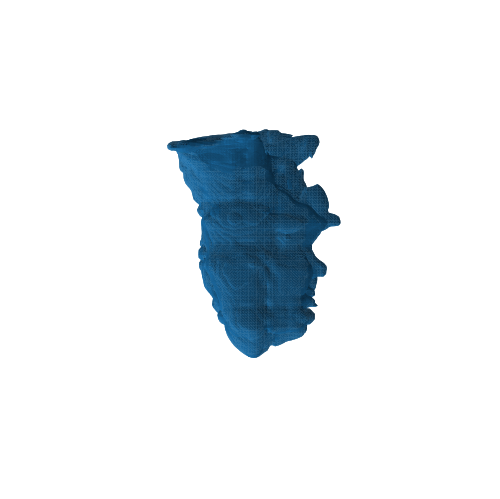

Rendering 0 -60


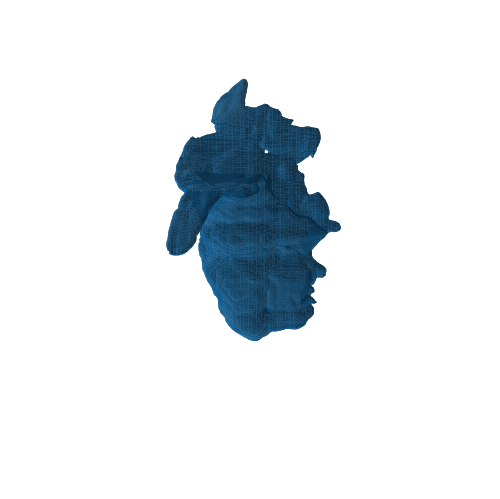

Rendering 0 -30


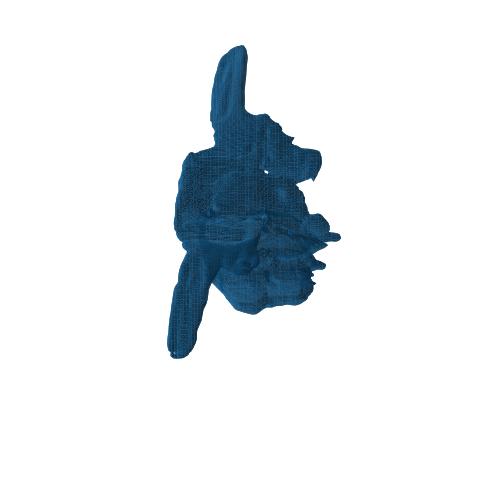

Rendering 0 0


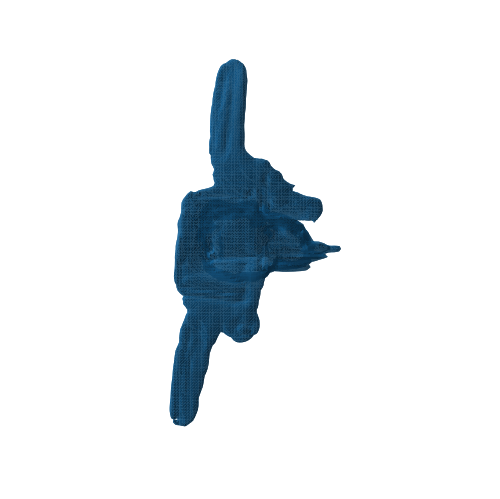

Rendering 0 30


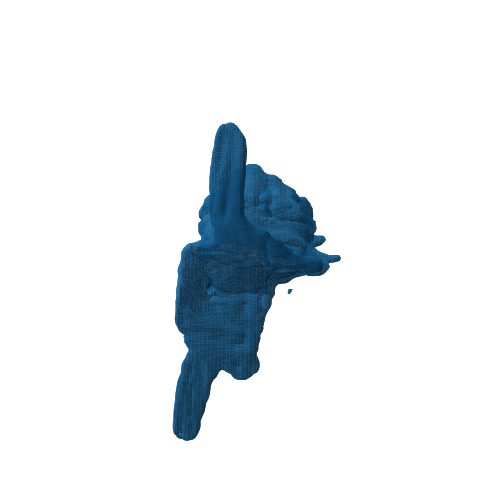

Rendering 0 60


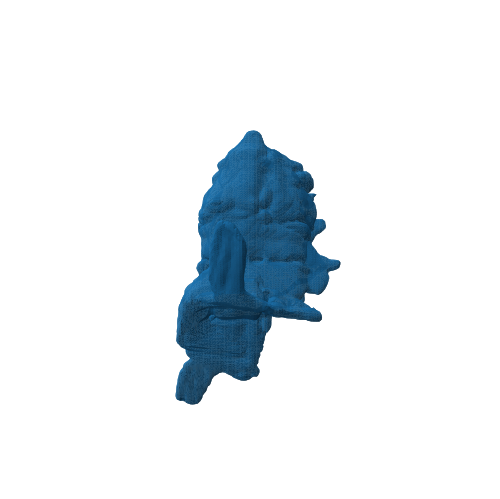

Rendering 30 -90


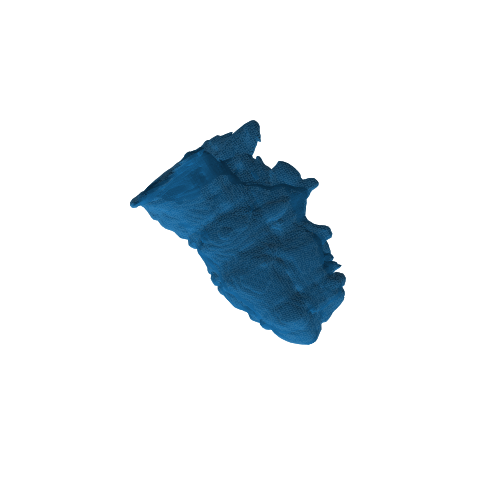

Rendering 30 -60


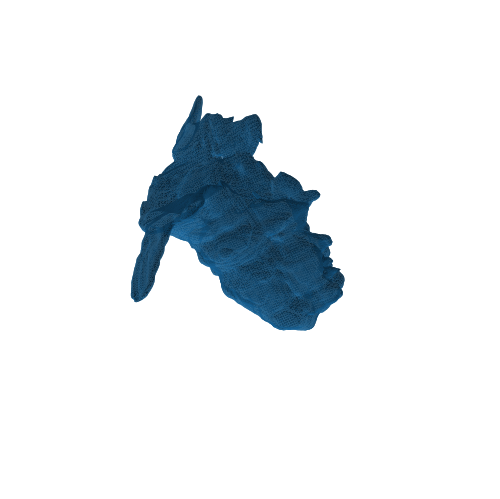

Rendering 30 -30


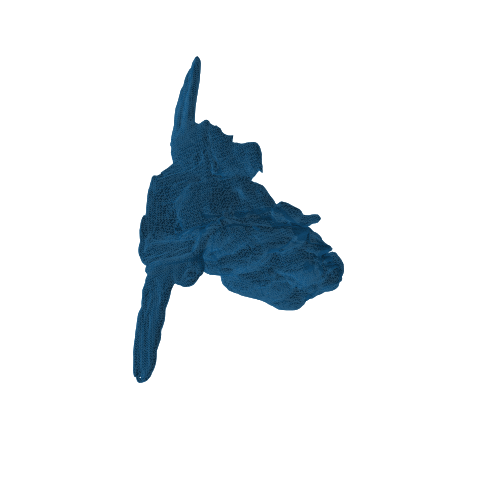

Rendering 30 0


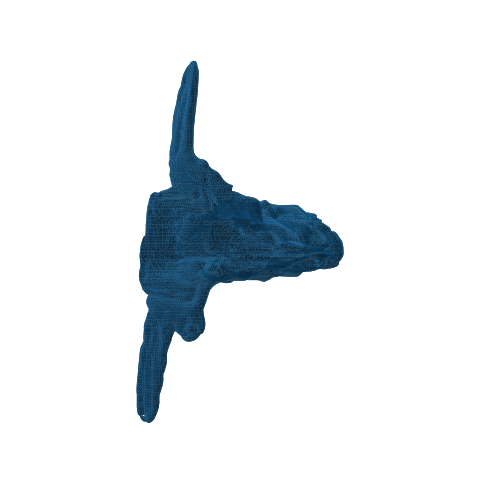

Rendering 30 30


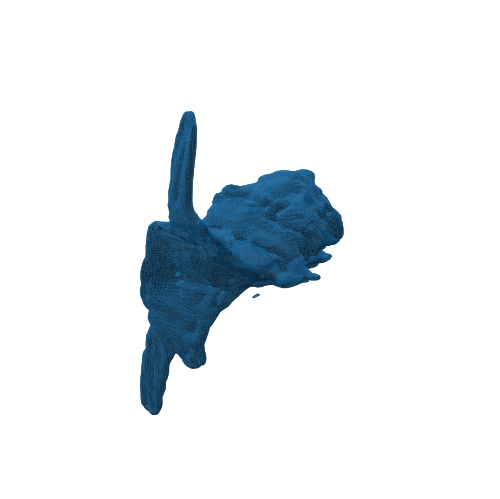

Rendering 30 60


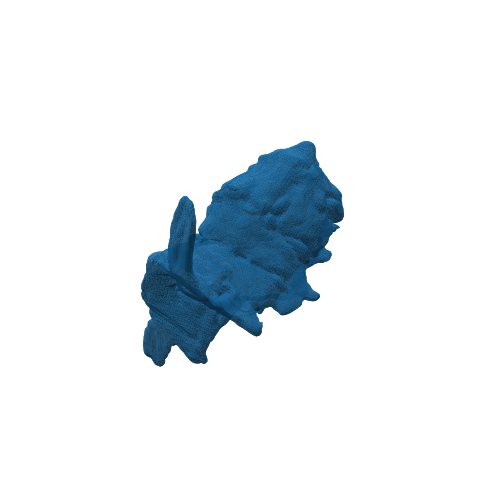

Rendering 60 -90


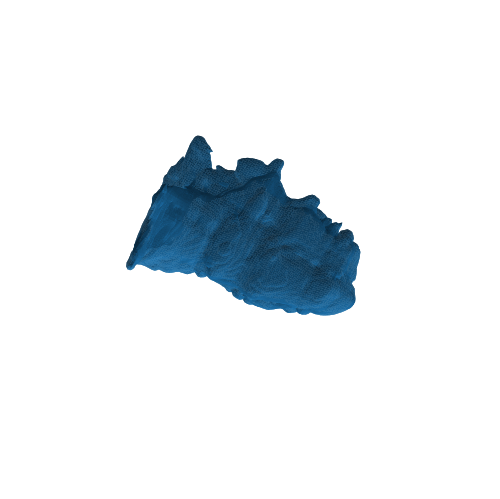

Rendering 60 -60


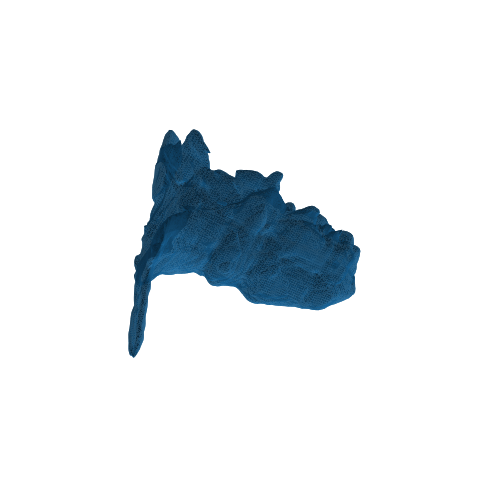

Rendering 60 -30


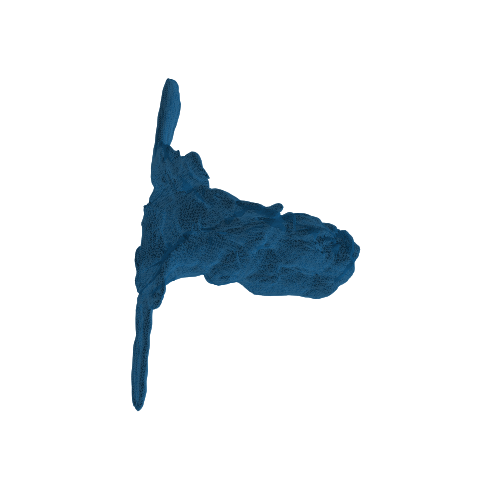

Rendering 60 0


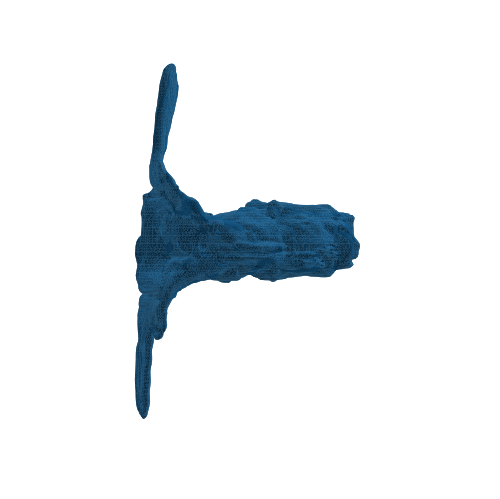

Rendering 60 30


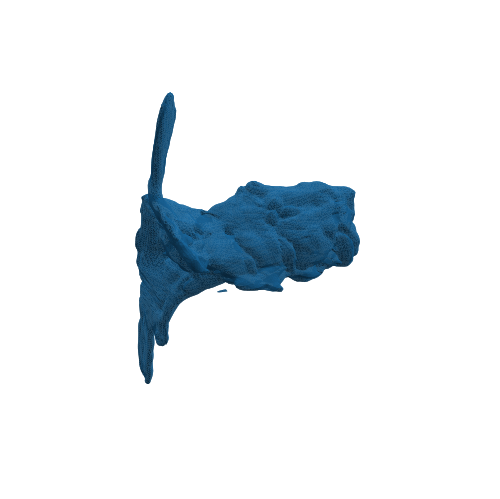

Rendering 60 60


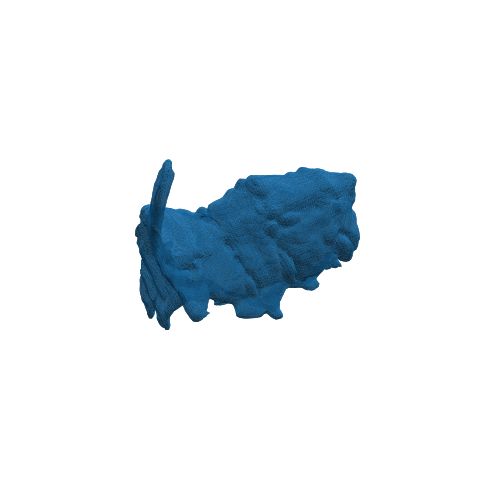

Rendering 90 -90


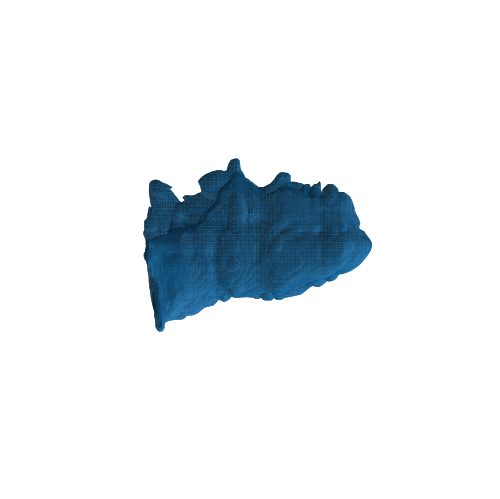

Rendering 90 -60


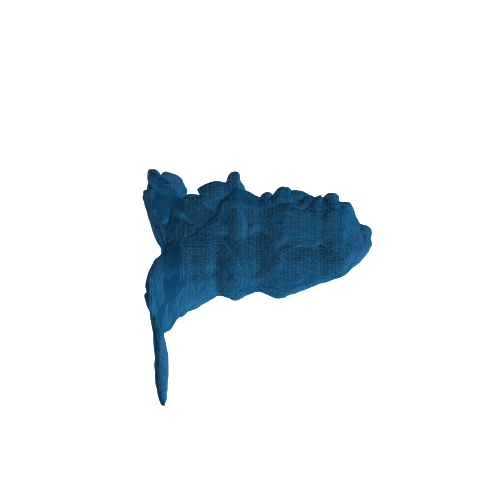

Rendering 90 -30


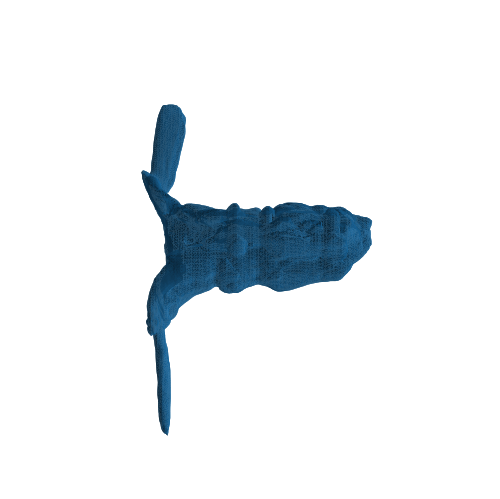

Rendering 90 0


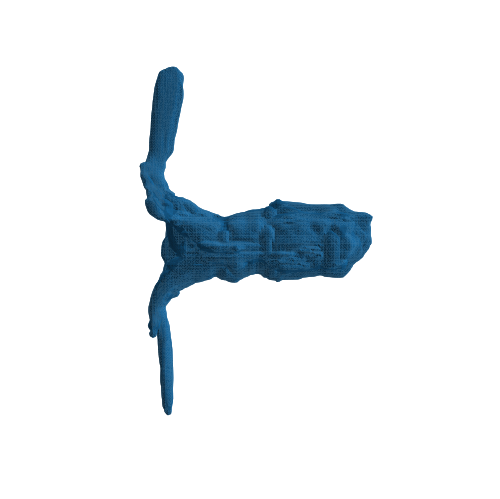

Rendering 90 30


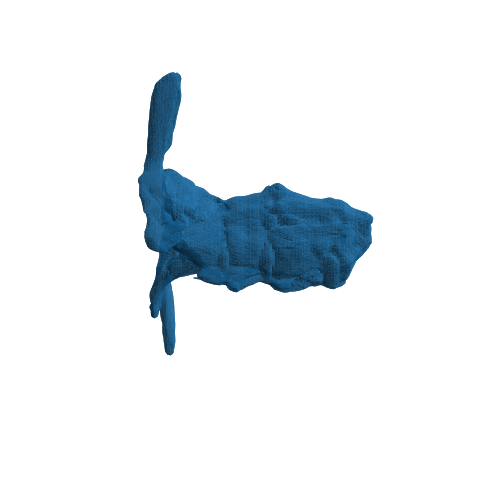

Rendering 90 60


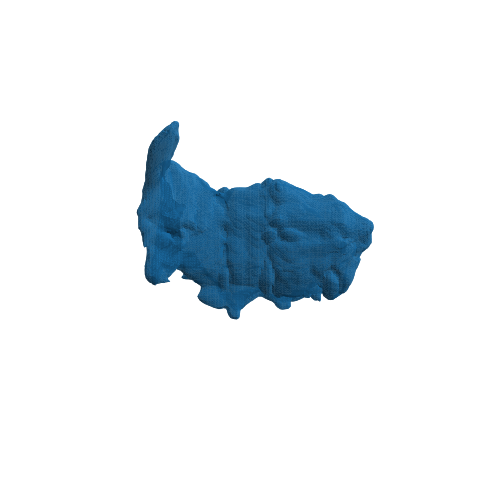

Rendering 120 -90


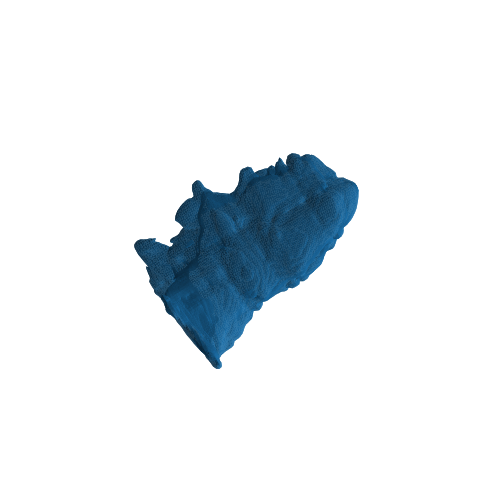

Rendering 120 -60


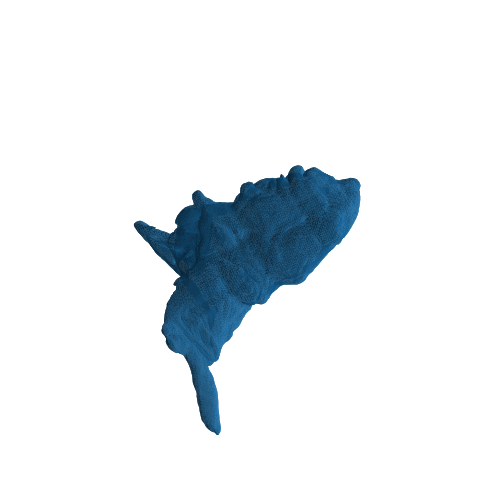

Rendering 120 -30


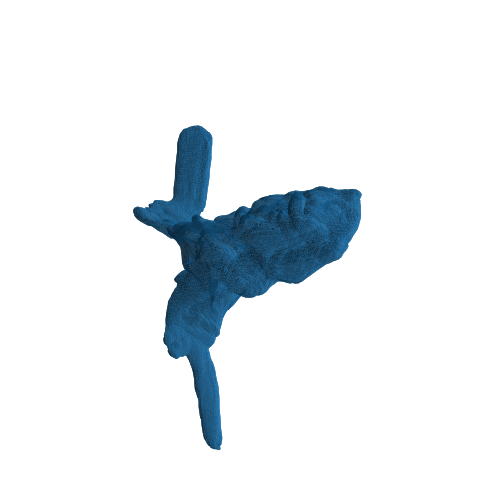

Rendering 120 0


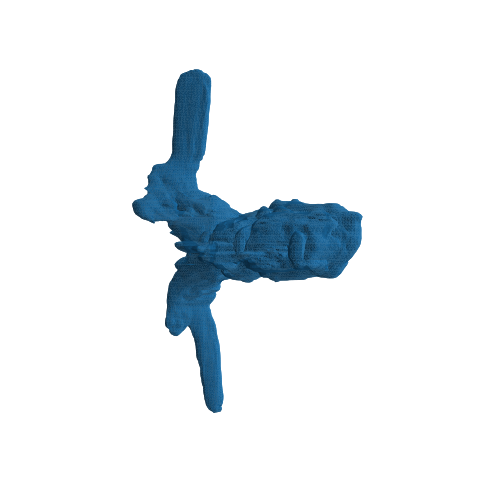

Rendering 120 30


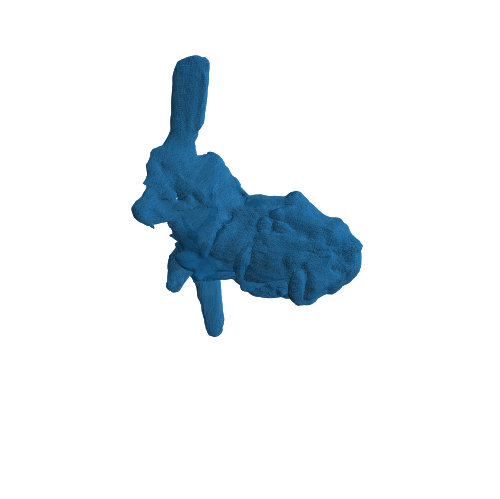

Rendering 120 60


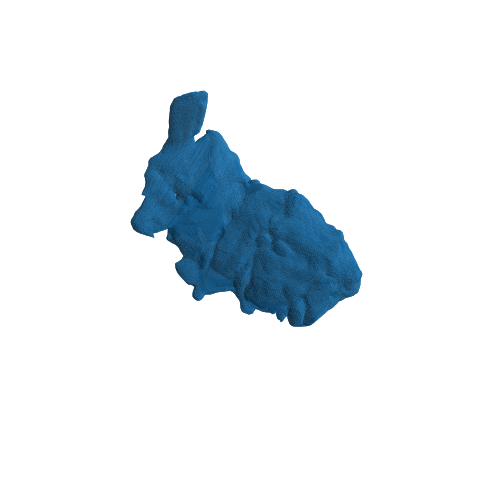

Rendering 150 -90


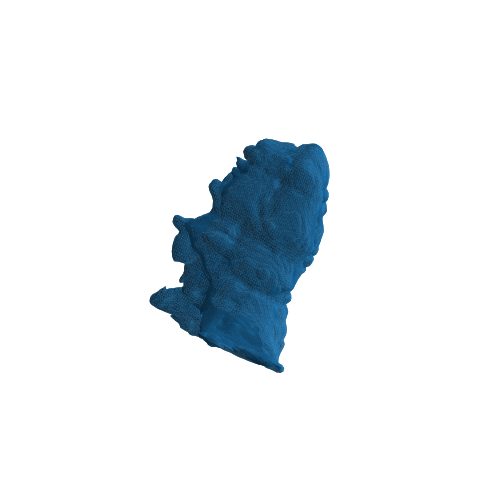

Rendering 150 -60


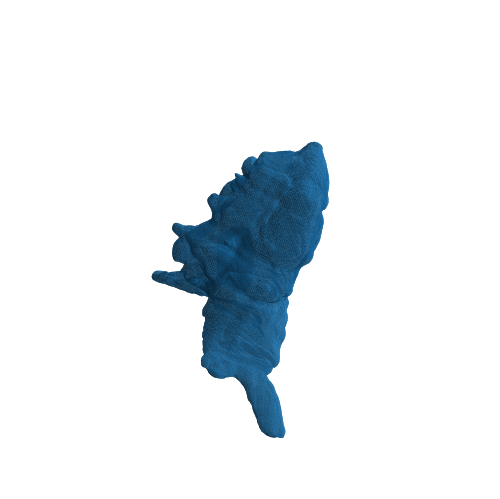

Rendering 150 -30


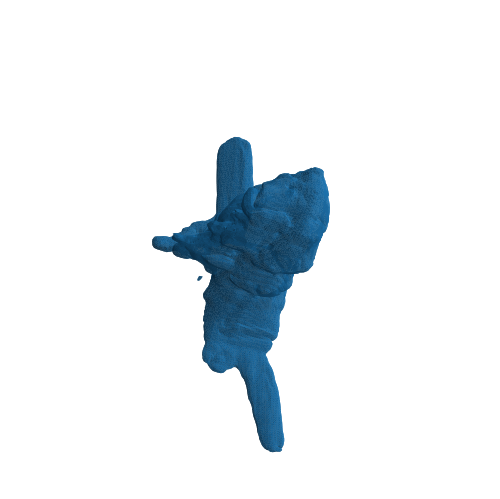

Rendering 150 0


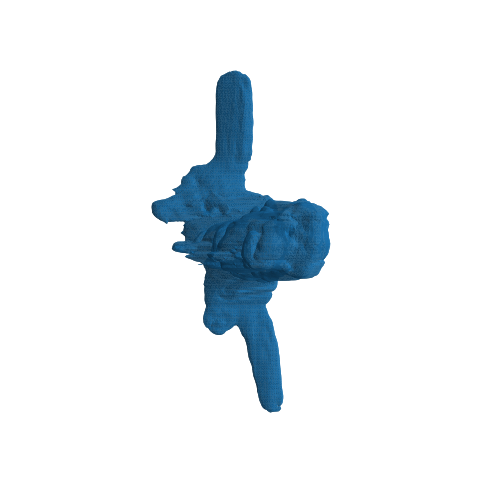

Rendering 150 30


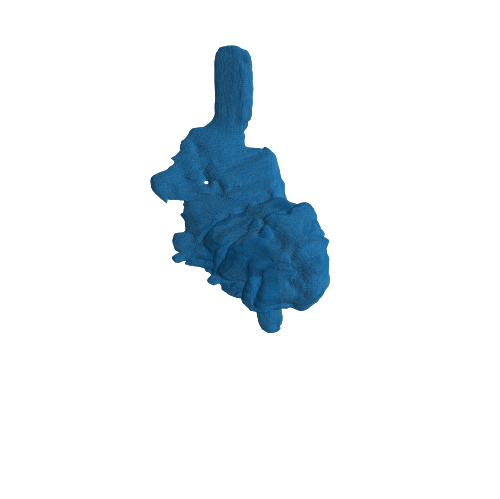

Rendering 150 60


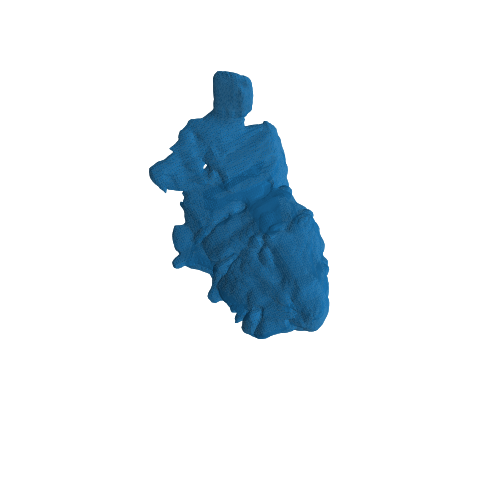

Rendering 180 -90


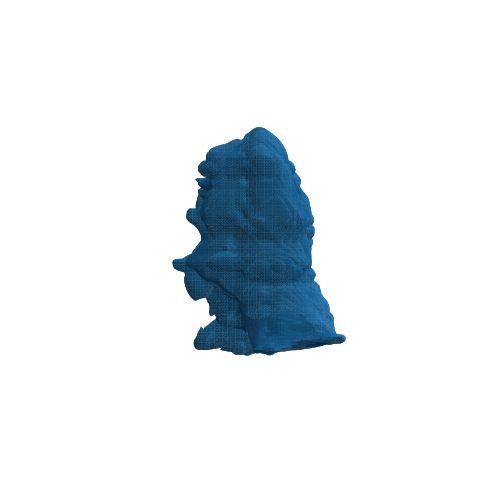

Rendering 180 -60


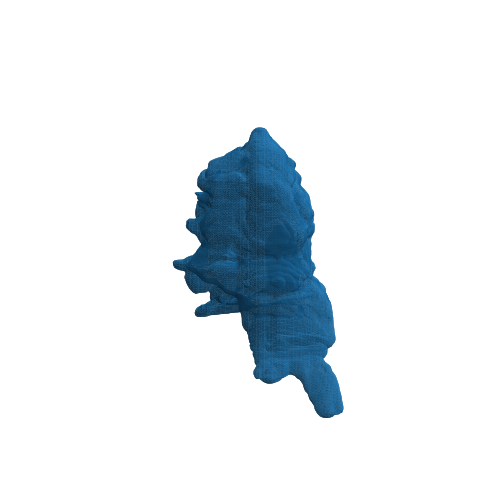

Rendering 180 -30


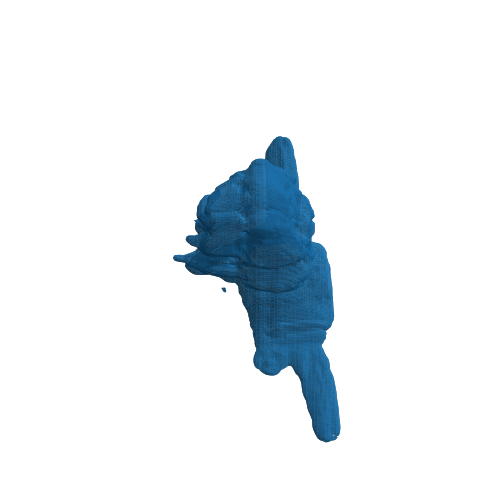

Rendering 180 0


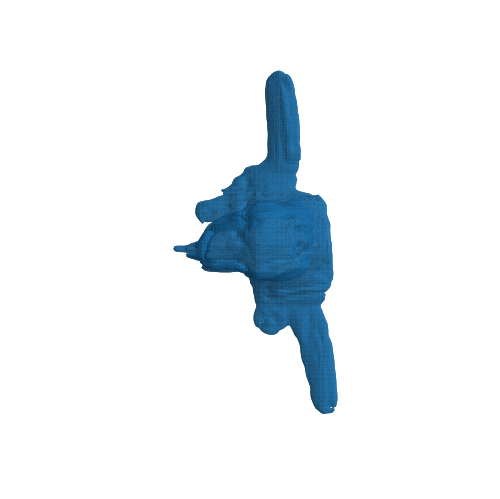

Rendering 180 30


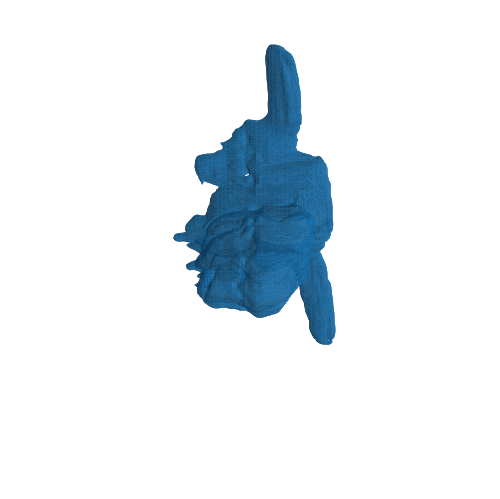

Rendering 180 60


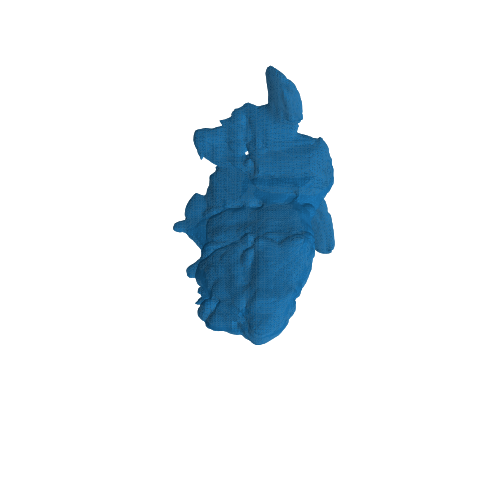

Rendering 210 -90


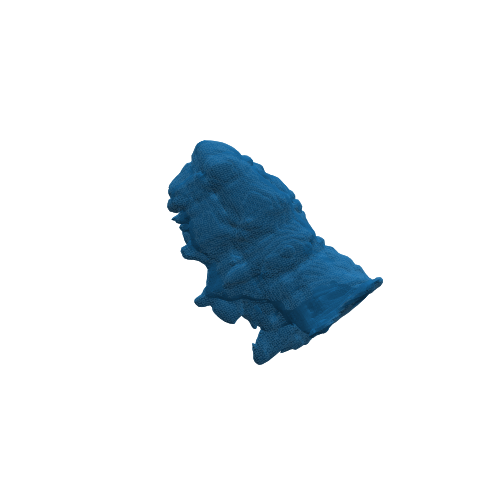

Rendering 210 -60


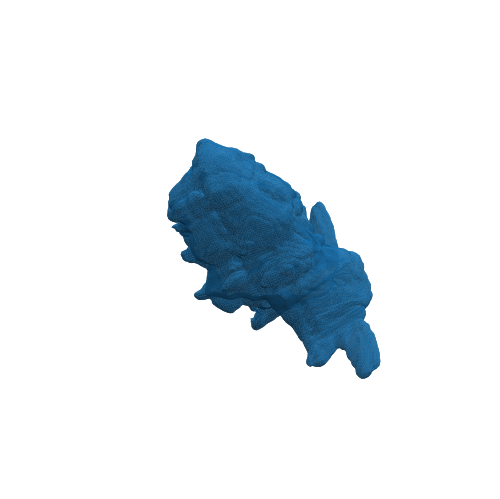

Rendering 210 -30


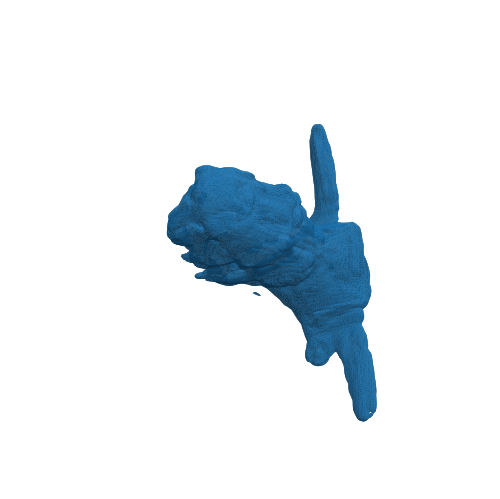

Rendering 210 0


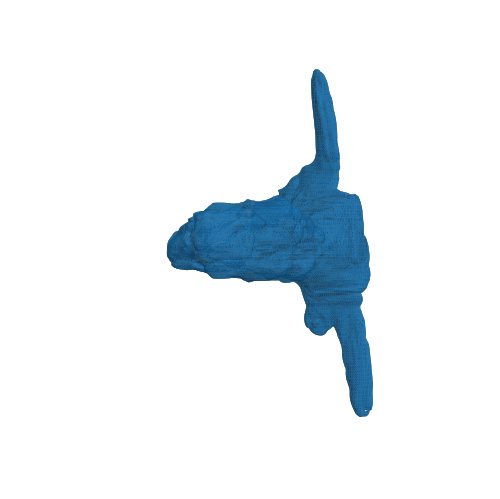

Rendering 210 30


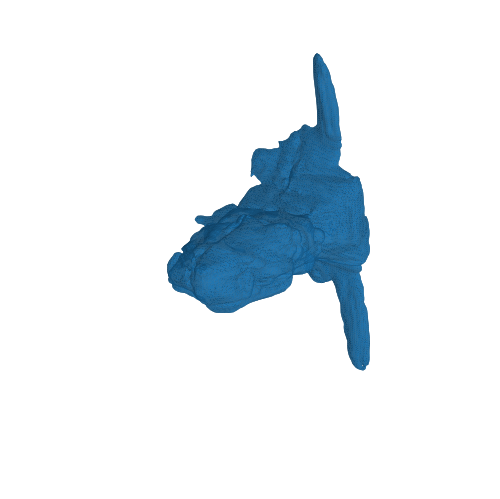

Rendering 210 60


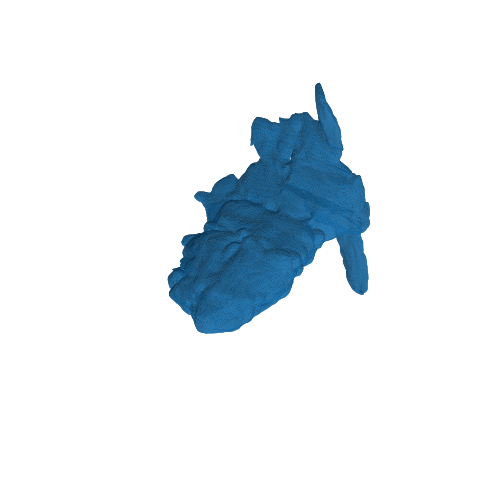

Rendering 240 -90


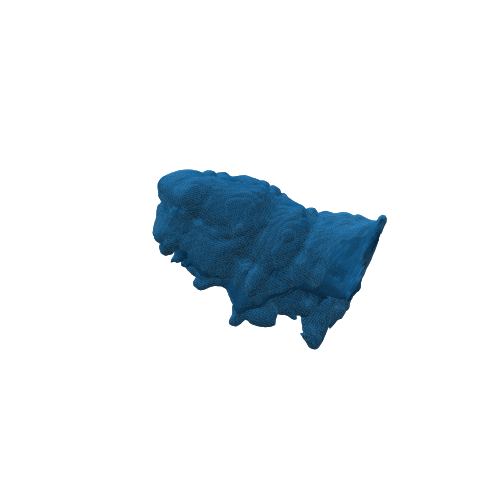

Rendering 240 -60


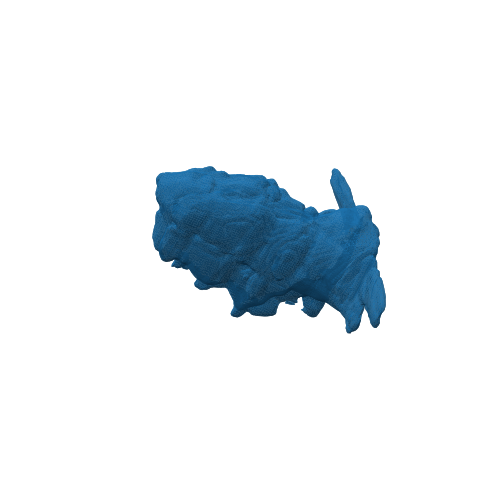

Rendering 240 -30


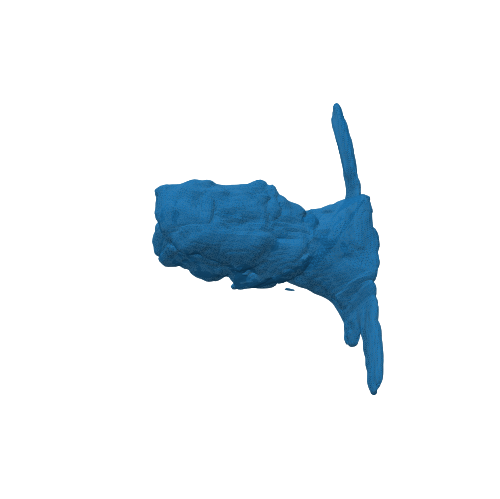

Rendering 240 0


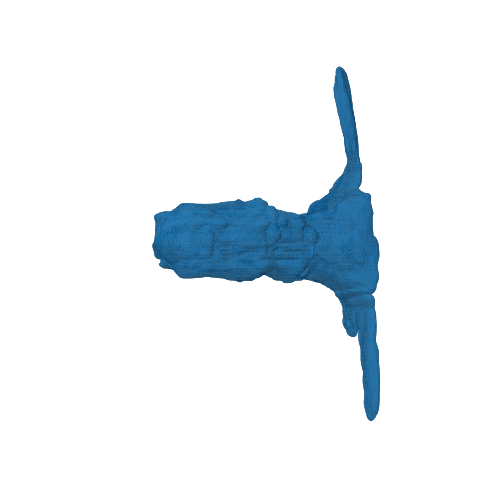

Rendering 240 30


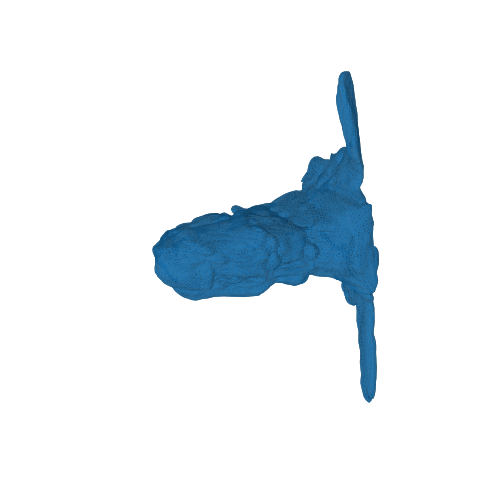

Rendering 240 60


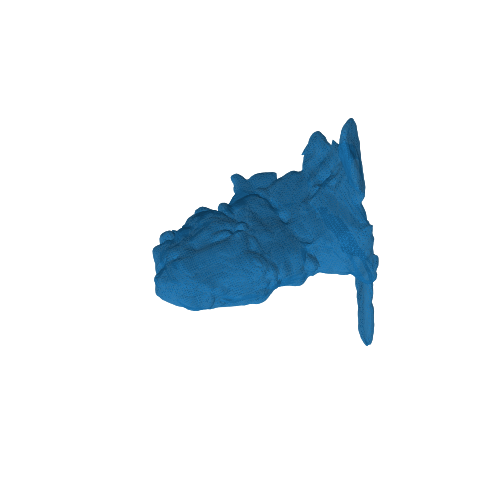

Rendering 270 -90


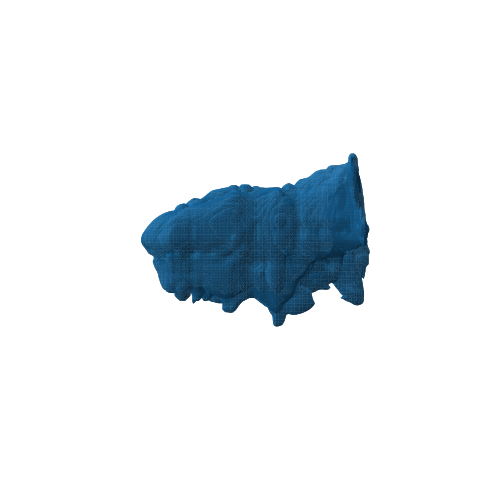

Rendering 270 -60


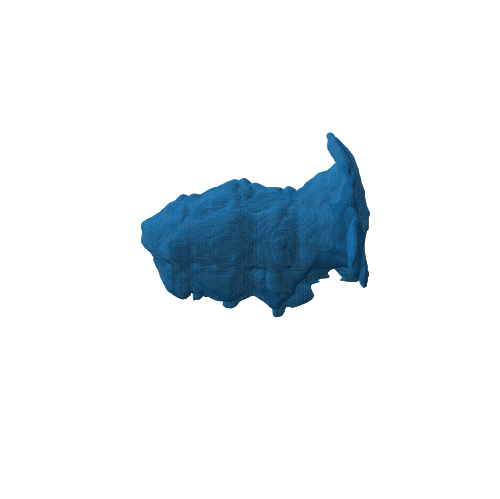

Rendering 270 -30


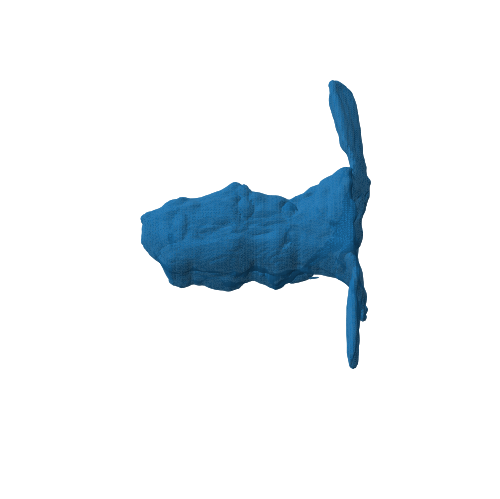

Rendering 270 0


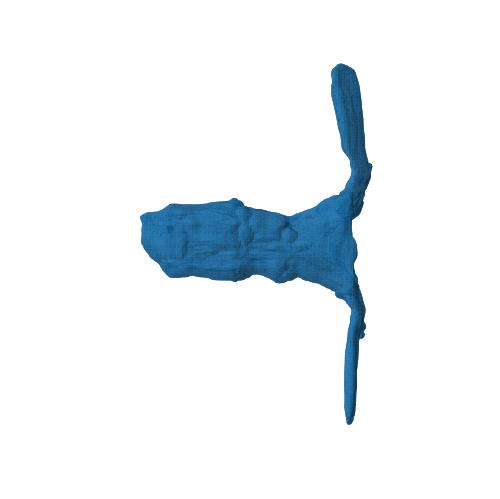

Rendering 270 30


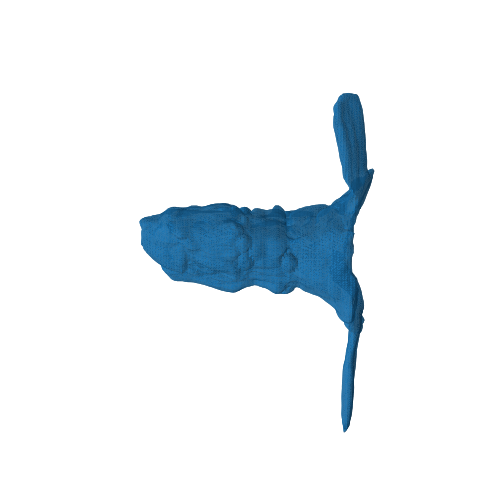

Rendering 270 60


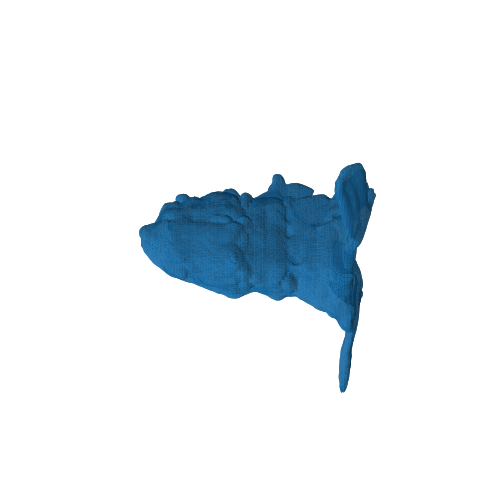

Rendering 300 -90


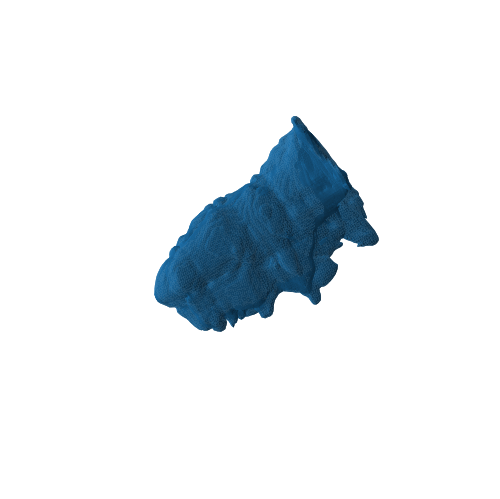

Rendering 300 -60


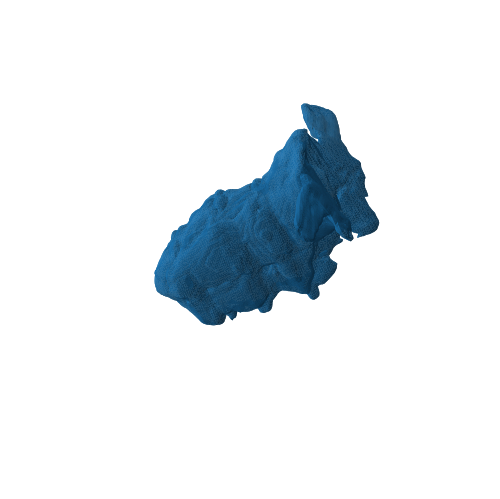

Rendering 300 -30


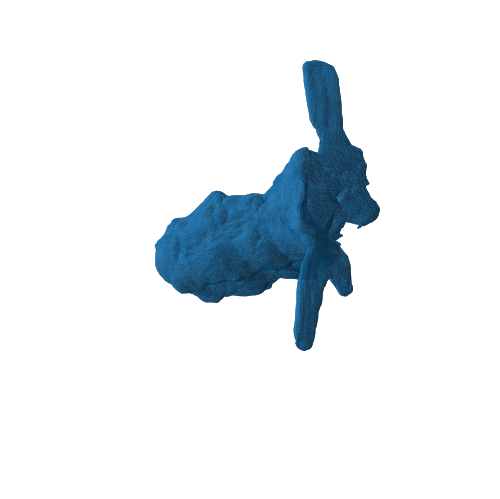

Rendering 300 0


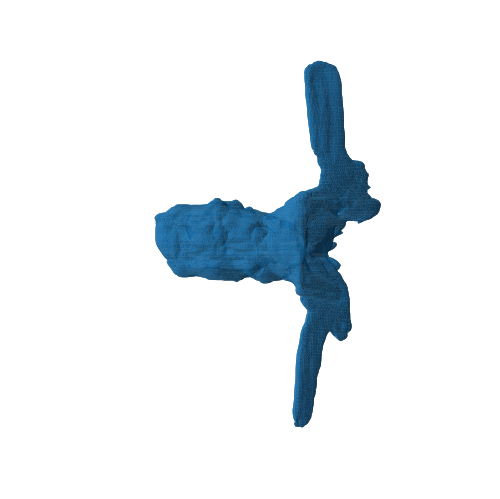

Rendering 300 30


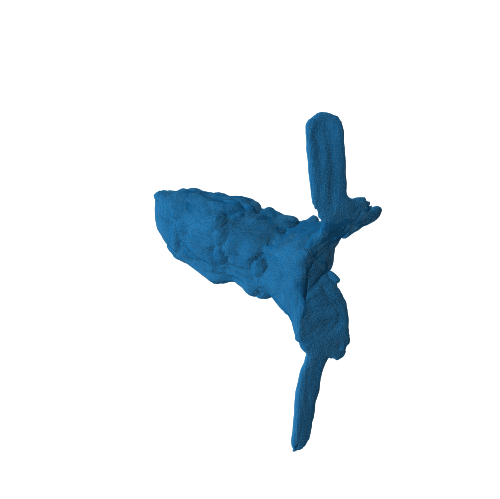

Rendering 300 60


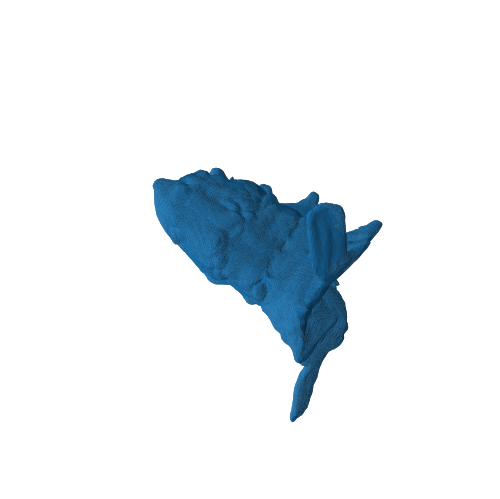

Rendering 330 -90


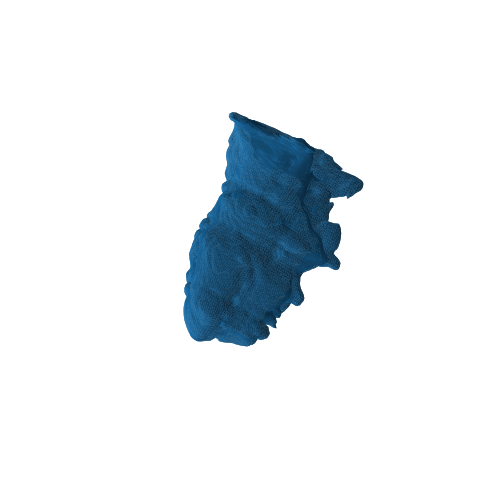

Rendering 330 -60


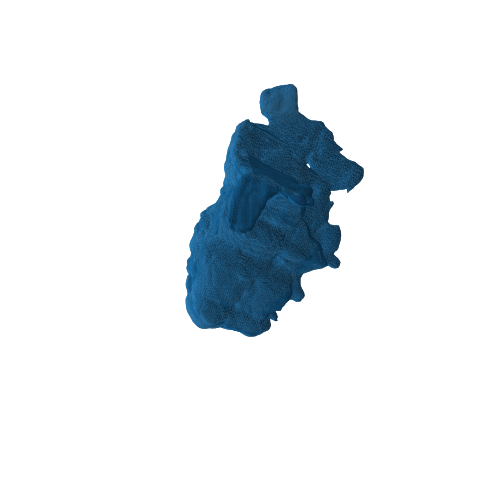

Rendering 330 -30


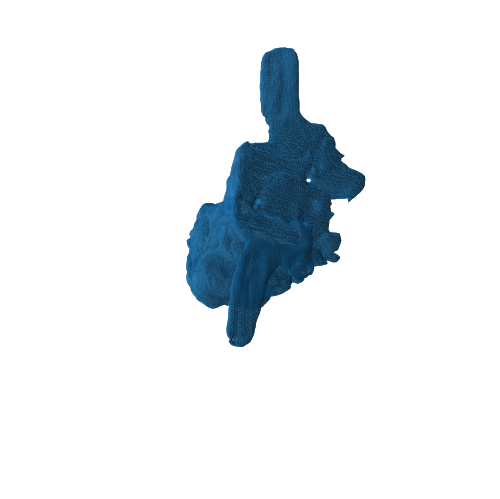

Rendering 330 0


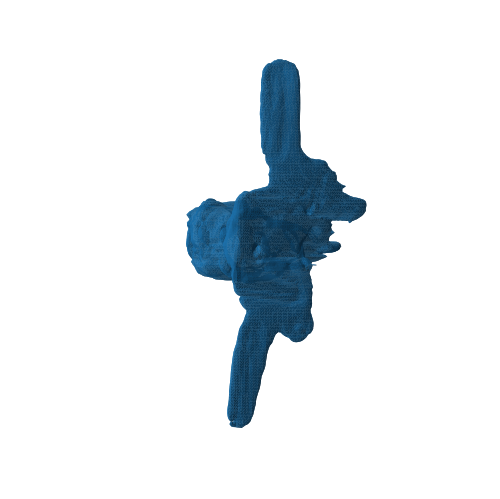

Rendering 330 30


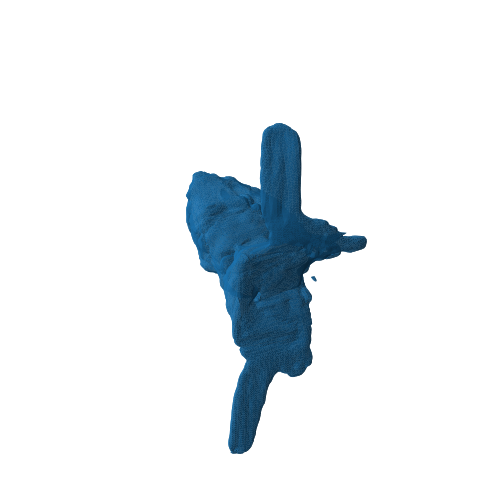

Rendering 330 60


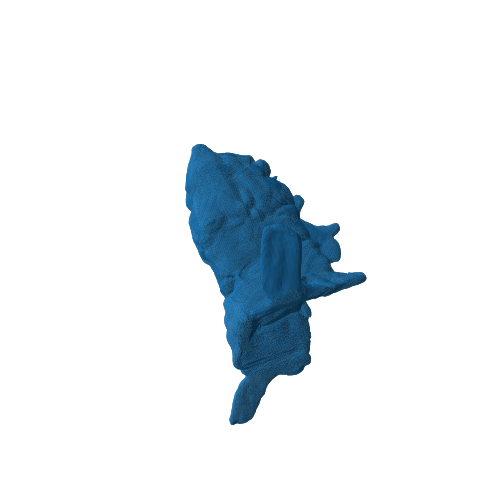

In [20]:
# create a series of images from 360 degrees horizontally and vertically
for i in range(0, 360, 30):
    for j in range(-90, 90, 30):
        print("Rendering %s %s" % (i, j))
        convert_obj_to_png(["output/0/mesh.obj"], outfile="output/0/mesh_%s_%s.png" % (i, j), azim=i, elevation=j, quality="LOW", view=True)
